In [143]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dt

In [144]:
X = np.genfromtxt("hw06_data_set_images.csv", delimiter = ",")
Y = np.genfromtxt("hw06_data_set_labels.csv",delimiter= ",")
x_train = X[:1000]
x_test = X[1000:]
y_train = Y[:1000]
y_test = Y[1000:]

In [145]:
y_test.shape

(1000,)

In [146]:
N_train = x_train.shape[0]
N = x_train.shape[1]
bin_width = 4
left_borders = np.arange(0, 256, bin_width)
right_borders = np.arange(0 + bin_width, 256 + bin_width, bin_width)
H_train = np.asarray([[np.sum((left_borders[b] <= x) & (x < right_borders[b])) / N for b in range(len(left_borders))] for x in x_train])
H_test = np.asarray([[np.sum((left_borders[b] <= x) & (x < right_borders[b])) / N for b in range(len(left_borders))] for x in x_test])

In [147]:
print(H_train[0:5,0:5])
print(H_test[0:5,0:5])

[[0.86479592 0.00127551 0.         0.00255102 0.        ]
 [0.66836735 0.         0.00127551 0.00127551 0.        ]
 [0.66454082 0.00637755 0.00382653 0.00765306 0.00892857]
 [0.65816327 0.00765306 0.00892857 0.00127551 0.00382653]
 [0.5625     0.00255102 0.00255102 0.00127551 0.        ]]
[[0.68239796 0.00255102 0.00127551 0.00127551 0.00127551]
 [0.69770408 0.01658163 0.00510204 0.00382653 0.01020408]
 [0.73341837 0.02678571 0.01530612 0.00510204 0.00637755]
 [0.63903061 0.00892857 0.00255102 0.00127551 0.        ]
 [0.75382653 0.00765306 0.00127551 0.00127551 0.        ]]


In [148]:
def hist_kernel(h1,h2):
    kernel = np.zeros((h1.shape[0],h1.shape[0]))
    for i in range(len(h1)):
        for j in range((len(h2))):
            kernel[i][j] = np.sum(np.minimum(h1[i],h2[j]))
    return kernel 

In [149]:
K_train = hist_kernel(H_train,H_train)
K_test = hist_kernel(H_test,H_train)

In [150]:
print(K_train[0:5,0:5])
print(K_test[0:5,0:5])

[[1.         0.72321429 0.77040816 0.75382653 0.62755102]
 [0.72321429 1.         0.73086735 0.78571429 0.68622449]
 [0.77040816 0.73086735 1.         0.84056122 0.70153061]
 [0.75382653 0.78571429 0.84056122 1.         0.76403061]
 [0.62755102 0.68622449 0.70153061 0.76403061 1.        ]]
[[0.77806122 0.80867347 0.82142857 0.88647959 0.79209184]
 [0.79464286 0.76403061 0.84566327 0.86607143 0.77933673]
 [0.8380102  0.74362245 0.85714286 0.83035714 0.68877551]
 [0.71556122 0.84438776 0.75       0.83418367 0.75765306]
 [0.84438776 0.76785714 0.82397959 0.84183673 0.73469388]]


In [151]:

yyK = np.matmul(y_train[:,None], y_train[None,:]) * K_train

# set learning parameters
C = 10
epsilon = 0.001

P = cvx.matrix(yyK)
q = cvx.matrix(-np.ones((N_train, 1)))
G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
A = cvx.matrix(1.0 * y_train[None,:])
b = cvx.matrix(0.0)
                    
# use cvxopt library to solve QP problems
result = cvx.solvers.qp(P, q, G, h, A, b)
alpha = np.reshape(result["x"], N_train)
alpha[alpha < C * epsilon] = 0
alpha[alpha > C * (1 - epsilon)] = C

# find bias parameter
support_indices, = np.where(alpha != 0)
active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
w0 = np.mean(y_train[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))

     pcost       dcost       gap    pres   dres
 0:  1.0887e+03 -6.1913e+04  1e+05  5e-01  5e-14
 1:  1.2396e+03 -1.1654e+04  1e+04  2e-14  6e-14
 2: -4.1568e+02 -3.9854e+03  4e+03  5e-14  6e-14
 3: -8.3426e+02 -2.5760e+03  2e+03  8e-14  7e-14
 4: -1.0562e+03 -1.7960e+03  7e+02  4e-14  8e-14
 5: -1.2018e+03 -1.4485e+03  2e+02  6e-14  9e-14
 6: -1.2586e+03 -1.3270e+03  7e+01  1e-14  1e-13
 7: -1.2782e+03 -1.2901e+03  1e+01  1e-14  1e-13
 8: -1.2826e+03 -1.2831e+03  5e-01  2e-14  1e-13
 9: -1.2828e+03 -1.2828e+03  1e-02  8e-14  1e-13
10: -1.2828e+03 -1.2828e+03  2e-04  4e-15  1e-13
Optimal solution found.


In [152]:
def svm(C,K_train,K_test,y_train,y_test):
    
   
    yyK = np.matmul(y_train[:,None], y_train[None,:]) * K_train

    # set learning parameters
    
    epsilon = 0.001

    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((N_train, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
    h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
    A = cvx.matrix(1.0 * y_train[None,:])
    b = cvx.matrix(0.0)
                    
    # use cvxopt library to solve QP problems
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N_train)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C

    # find bias parameter
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y_train[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    f_predicted_train = np.matmul(K_train, y_train[:,None] * alpha[:,None]) + w0
    y_predicted_train = 2 * (f_predicted_train > 0.0) - 1
    f_predicted_test = np.matmul(K_test, y_train[:,None] * alpha[:,None]) + w0
    y_predicted_test = 2 * (f_predicted_test > 0.0) - 1
    y_pred_train = np.concatenate(y_predicted_train)
    y_pred_test = np.concatenate(y_predicted_test)
    acc_train = (y_train == y_pred_train).sum()/len(y_train)
    acc_test = (y_test == y_pred_test).sum() / len(y_test)
    
    return y_predicted_train,y_predicted_test,acc_train,acc_test

In [153]:
y_predicted_train,y_predicted_test,_,_ = svm(10,K_train,K_test,y_train,y_test)


     pcost       dcost       gap    pres   dres
 0:  1.0887e+03 -6.1913e+04  1e+05  5e-01  5e-14
 1:  1.2396e+03 -1.1654e+04  1e+04  2e-14  6e-14
 2: -4.1568e+02 -3.9854e+03  4e+03  5e-14  6e-14
 3: -8.3426e+02 -2.5760e+03  2e+03  8e-14  7e-14
 4: -1.0562e+03 -1.7960e+03  7e+02  4e-14  8e-14
 5: -1.2018e+03 -1.4485e+03  2e+02  6e-14  9e-14
 6: -1.2586e+03 -1.3270e+03  7e+01  1e-14  1e-13
 7: -1.2782e+03 -1.2901e+03  1e+01  1e-14  1e-13
 8: -1.2826e+03 -1.2831e+03  5e-01  2e-14  1e-13
 9: -1.2828e+03 -1.2828e+03  1e-02  8e-14  1e-13
10: -1.2828e+03 -1.2828e+03  2e-04  4e-15  1e-13
Optimal solution found.


In [154]:
confusion_matrix_train = pd.crosstab(np.reshape(y_predicted_train, N_train), y_train,
                                     rownames = ["y_predicted"], colnames = ["y_train"])

confusion_matrix_test = pd.crosstab(np.reshape(y_predicted_test, N_train), y_test,
                                     rownames = ["y_predicted"], colnames = ["y_test"])
print(confusion_matrix_train)
print(confusion_matrix_test)

y_train      -1.0   1.0
y_predicted            
-1            484     9
 1              9   498
y_test       -1.0   1.0
y_predicted            
-1            466    25
 1             37   472


In [159]:
train_error = {}
test_error = {}
C = np.arange(-1,3.5,0.5)
print(C)

for i in C:
    _,_,train,test = svm(10 ** i,K_train,K_test,y_train,y_test)

    train_error[i] = train
    test_error[i] = test

[-1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3. ]
     pcost       dcost       gap    pres   dres
 0: -1.8751e+02 -2.4438e+02  7e+03  3e+01  5e-15
 1: -6.2127e+01 -2.2353e+02  5e+02  1e+00  4e-15
 2: -4.8341e+01 -1.2857e+02  8e+01  8e-16  3e-15
 3: -5.3798e+01 -6.6369e+01  1e+01  3e-15  2e-15
 4: -5.7212e+01 -6.1182e+01  4e+00  8e-16  2e-15
 5: -5.8516e+01 -5.9343e+01  8e-01  3e-15  2e-15
 6: -5.8814e+01 -5.8991e+01  2e-01  5e-16  2e-15
 7: -5.8883e+01 -5.8910e+01  3e-02  3e-15  2e-15
 8: -5.8895e+01 -5.8897e+01  2e-03  4e-15  2e-15
 9: -5.8896e+01 -5.8896e+01  3e-05  7e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1663e+02 -7.2291e+02  8e+03  8e+00  6e-15
 1: -1.1031e+02 -6.1711e+02  7e+02  3e-01  5e-15
 2: -1.1254e+02 -1.8088e+02  7e+01  1e-02  3e-15
 3: -1.2553e+02 -1.5831e+02  3e+01  5e-03  3e-15
 4: -1.3428e+02 -1.4269e+02  9e+00  1e-03  4e-15
 5: -1.3682e+02 -1.3946e+02  3e+00  2e-04  4e-15
 6: -1.3789e+02 -1.3812e+02  2e-01  3e-06  5e-15


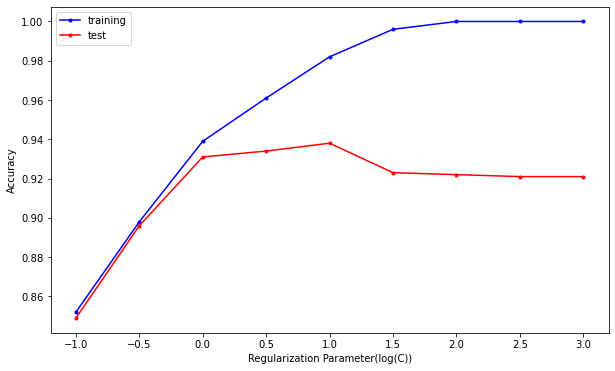

In [163]:

plt.figure(figsize = (10,6))
plt.plot(train_error.keys(),train_error.values(),".b-",label = "training")
plt.plot(test_error.keys(),test_error.values(),".r-",label = "test")
plt.xlabel("Regularization Parameter(log(C))")
plt.ylabel("Accuracy")
plt.legend(frameon= True)
plt.show()
